In [1]:
#Import Necessary Library's
import pandas as pd
import numpy as np
import re
import json
from pathlib import Path
import seaborn as sn
import matplotlib.pyplot as pyplot

In [2]:
#Set up file path
data_folder = Path("./Data/")

In [3]:
HappinessFile = data_folder / "2019 Happiness Data.csv"

#Import Data to Pandas DataFrame
happinessDF = pd.read_csv(HappinessFile)
happinessDF2 = happinessDF.drop(happinessDF.columns.difference(["Country or region", "Score"]), axis = 1)
happinessDF2.rename(columns = {"Score": "Happiness Score", "Country or region": "Country Name"}, inplace = True)
happinessDF2.set_index("Country Name", inplace = True)

In [4]:
#Import Data
FreedomFile = data_folder / "economic_freedom_index2019_data.csv"

#Import Data to Pandas DataFrame
economicFreedomDF = pd.read_csv(FreedomFile,encoding='latin-1')
economicFreedomDF = economicFreedomDF.dropna(subset=["World Rank"])
economicFreedomDF2 = economicFreedomDF.drop(economicFreedomDF.columns.difference(["Country Name","2019 Score","Financial Freedom", "Population (Millions)", "Unemployment (%)", "Inflation (%)"]), axis = 1)
economicFreedomDF2.rename(columns = {"2019 Score": "Economic Freedom"}, inplace = True)
economicFreedomDF2.set_index("Country Name", inplace = True)

In [5]:
#Import Data
GDPData = data_folder / "GDPfinal.json"

# read in json file of GDP data 
GDPDF = pd.read_json(GDPData)

GDPDF2 = GDPDF.drop(GDPDF.columns.difference(["Country","Growth Rate", "GDP (IMF)", "GDP Per Capita"]), 1)
GDPDF2.drop(GDPDF2.index[GDPDF2["GDP (IMF)"] == "-"], inplace=True)
GDPDF2.dropna(subset=["Growth Rate"], inplace = True)
GDPDF2.rename(columns = {"GDP (IMF)": "GDP (Billions)", "Country": "Country Name"}, inplace = True)
GDPDF2.set_index("Country Name", inplace = True)

for rowlabel, rowseries in GDPDF2.iterrows():
    GDPDF2.loc[rowlabel, "GDP Per Capita"] = float(re.sub("[^0-9.]", "", GDPDF2.loc[rowlabel, "GDP Per Capita"]))
    GDPDF2.loc[rowlabel, "Growth Rate"] = float(re.sub("[^0-9.]", "", GDPDF2.loc[rowlabel, "Growth Rate"]))
    
    gdp = GDPDF2.loc[rowlabel, "GDP (Billions)"]
    gdpMag = gdp[-2:]
    gdpClean = float(re.sub("[^0-9.]", "", gdp))
    
    if gdpMag == "Tn":
        GDPDF2.loc[rowlabel, "GDP (Billions)"] = gdpClean * 1000
    elif gdpMag == "Bn":
        GDPDF2.loc[rowlabel, "GDP (Billions)"] = gdpClean
    elif gdpMag == "Mn":
        GDPDF2.loc[rowlabel, "GDP (Billions)"] = gdpClean/1000

C:\Users\Test\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


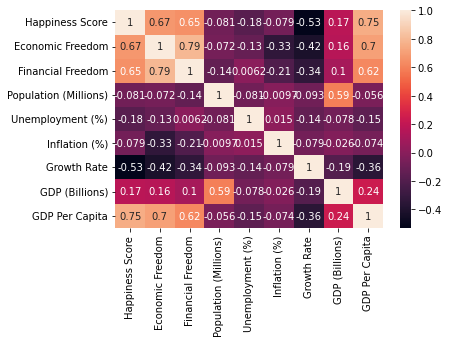

In [6]:
df = happinessDF2.join(economicFreedomDF2, on = 'Country Name', how = "inner")
df_final = df.join(GDPDF2, on = 'Country Name', how = "inner")
df_final = df_final.astype(float)
corrMatrix = df_final.corr(method = "pearson")
sn.heatmap(corrMatrix, annot=True)
pyplot.show()

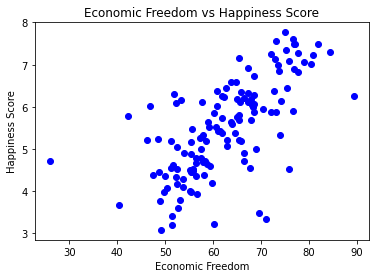

In [7]:
pyplot.plot(df_final["Economic Freedom"],df_final["Happiness Score"], "bo")
pyplot.xlabel("Economic Freedom")
pyplot.ylabel("Happiness Score")
pyplot.title("Economic Freedom vs Happiness Score")
pyplot.show()

In [8]:
x = df_final["Economic Freedom"]
y = df_final["Happiness Score"]

A = np.vstack([x, np.ones(len(x))]).T

In [9]:
model, SSE = np.linalg.lstsq(A, y, rcond=None)[:2]

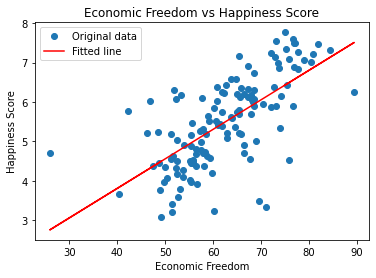

In [10]:
_ = pyplot.plot(x, y, 'o', label='Original data')
_ = pyplot.plot(x, model[0]*x + model[1], 'r', label='Fitted line')
_ = pyplot.xlabel("Economic Freedom")
_ = pyplot.ylabel("Happiness Score")
_ = pyplot.title("Economic Freedom vs Happiness Score")
_ = pyplot.legend()
pyplot.show()

In [11]:
#Find R^2 of model
rSquare2 = 1 - SSE[0] / sum((y - y.mean())**2) 
rSquare2

0.45229802223883764

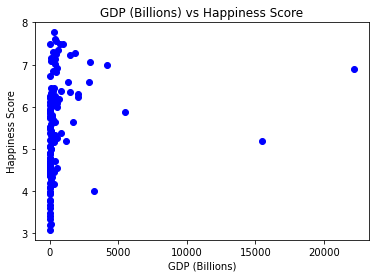

In [12]:
#Second Model
pyplot.plot(df_final["GDP (Billions)"],df_final["Happiness Score"], "bo") #Covers several orders of magnitude
pyplot.xlabel("GDP (Billions)")
pyplot.ylabel("Happiness Score")
pyplot.title("GDP (Billions) vs Happiness Score")
pyplot.show()

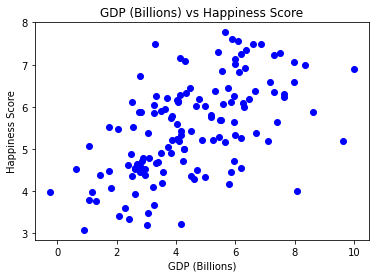

In [13]:
#Transform GDP Billions
pyplot.plot(np.log(df_final["GDP (Billions)"]),df_final["Happiness Score"], "bo") #Covers several orders of magnitude
pyplot.xlabel("GDP (Billions)")
pyplot.ylabel("Happiness Score")
pyplot.title("GDP (Billions) vs Happiness Score")
pyplot.show()

In [14]:
x2 = np.log(df_final["GDP (Billions)"])
y2 = df_final["Happiness Score"]

A2 = np.vstack([x2, np.ones(len(x2))]).T

In [15]:
model2, SSE2 = np.linalg.lstsq(A2, y2, rcond=None)[:2]

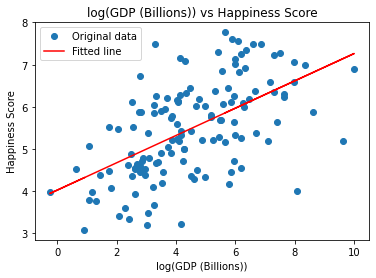

In [16]:
_ = pyplot.plot(x2, y2, 'o', label='Original data')
_ = pyplot.plot(x2, model2[0]*x2 + model2[1], 'r', label='Fitted line')
_ = pyplot.xlabel("log(GDP (Billions))")
_ = pyplot.ylabel("Happiness Score")
_ = pyplot.title("log(GDP (Billions)) vs Happiness Score")
_ = pyplot.legend()
pyplot.show()


##### Have to take the log of whatever you predict

In [17]:
#Finding R^2 for second model
rSquare2 = 1 - SSE2[0] / sum((y2 - y2.mean())**2) 
rSquare2

0.3190029292906227

Below is the old way we were importing data. Keeping it in case new way does not work.

In [ ]:
#fileName = "./Data/2019 Happiness Data.csv"
#happinessDF = pd.read_csv(fileName) 

#fileName = "./Data/economic_freedom_index2019_data.csv"
#economicFreedomDF = pd.read_csv(fileName,encoding='latin-1')


#json_file = open("countries.geo.json", "r")
#countries_geojson = json.load(json_file)

#json_file = open("factbook-country-profiles.json", "r")
#factbook = json.loads(json.dumps("factbook-country-profiles.json"))

In [ ]:
factbook-country-profiles.json = factbook-country-profiles.json.replace("\'", "\"")
json_file = open("factbook-country-profiles.json", "r")
factbook = json.load(json_file)

In [ ]:
factbook = json.loads(json.dumps("factbook-country-profiles.json"))

In [ ]:
String exampleRequest = FileUtils.readFileToString(new File("exampleJsonRequest.json"), StandardCharsets.UTF_8);
factbook

In [ ]:
json.load(json_file)